<a href="https://colab.research.google.com/github/jeswinfrancis/FeynnLabsProjects/blob/main/Mental_Health_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install scikit-plot


In [1]:
import numpy as np # linear algebra
import pandas as pd

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
data = pd.read_csv('/content/mental_health.csv')
data.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [10]:
print(data.shape)

(27977, 2)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


**Bar and Pie plot by '0' and '1'**

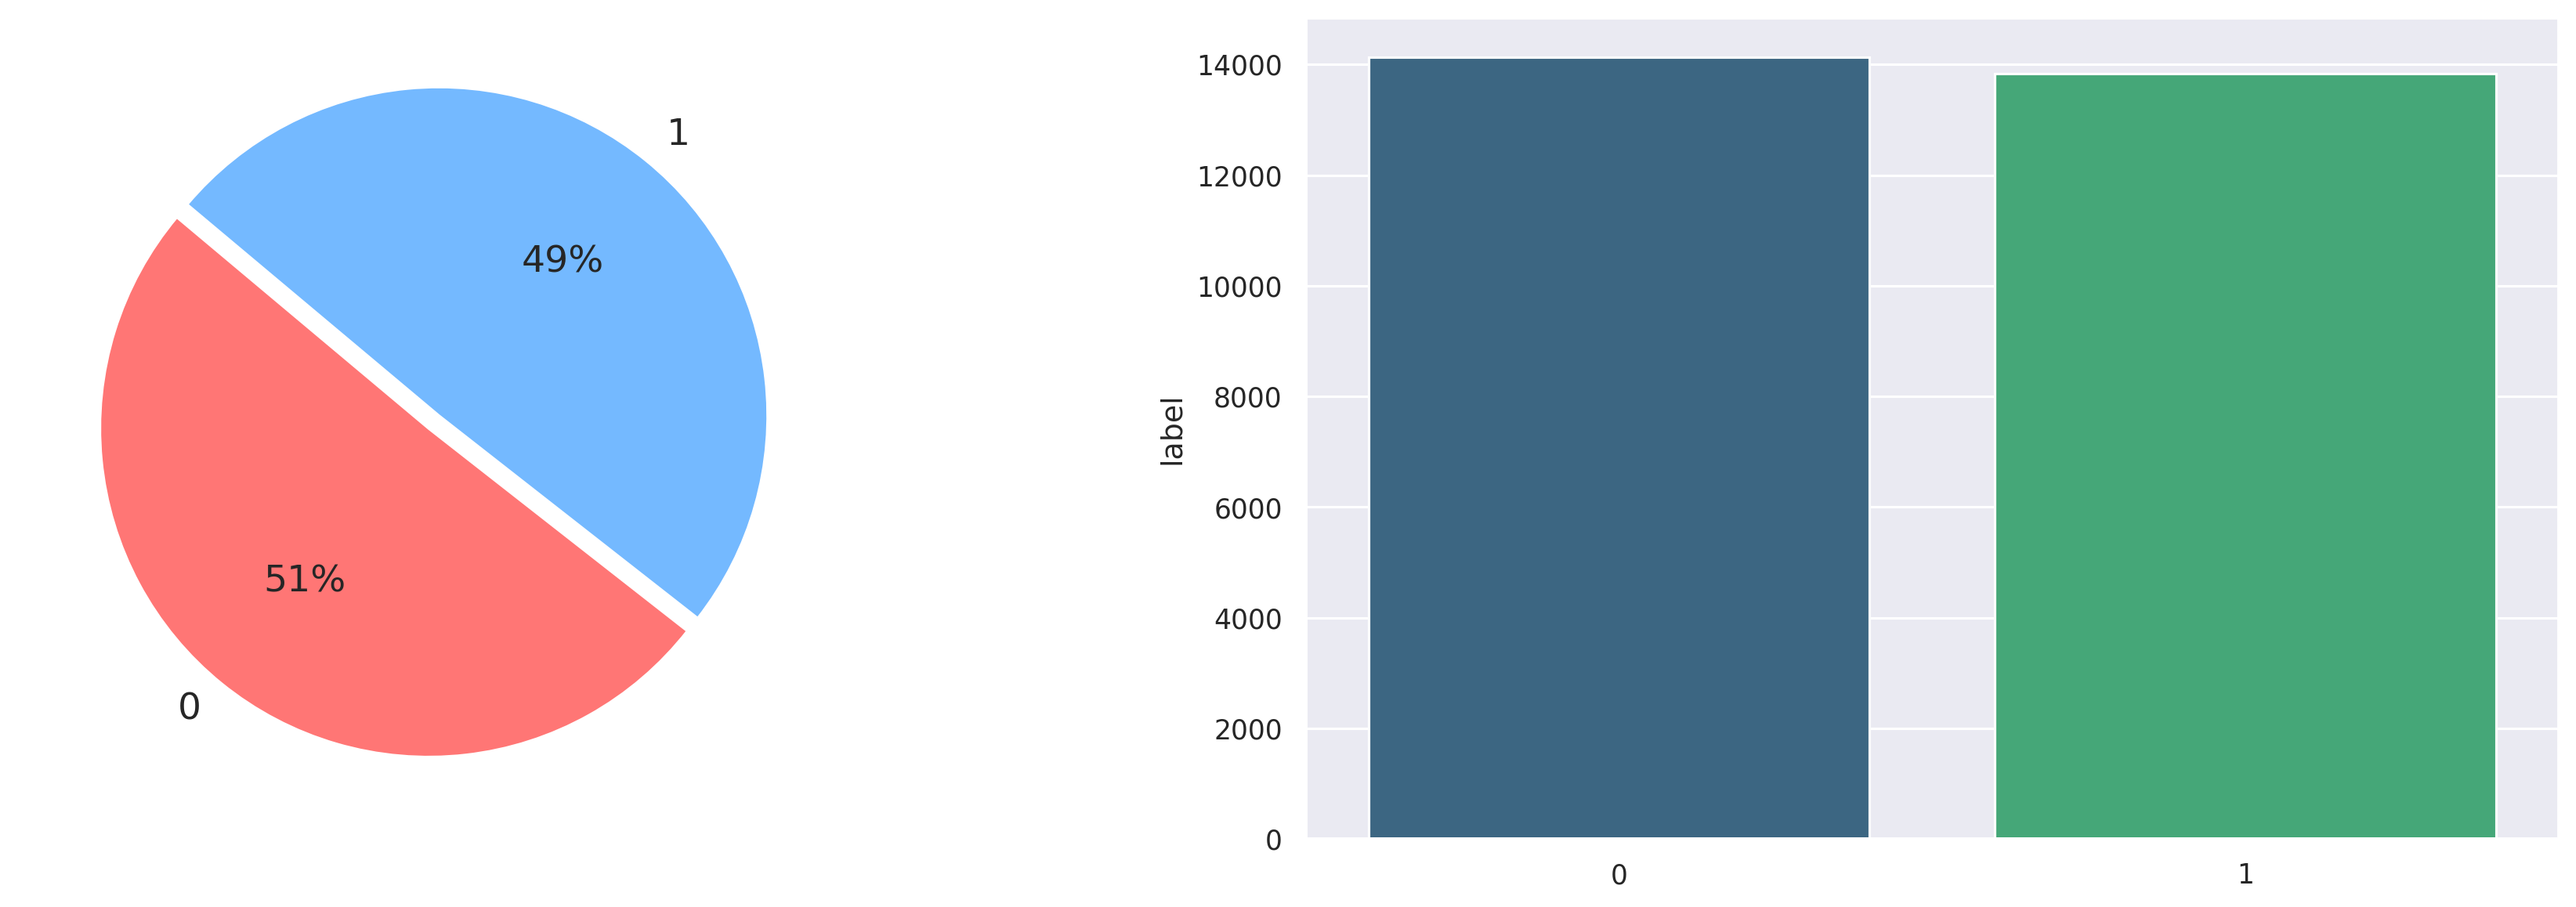

In [13]:
labels = [0, 1]
sizes = [14139, 13838]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140,
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = data['label'].unique(), y = data['label'].value_counts(), palette= 'viridis')

plt.show()

**Creating new columns 'Total Words' and 'Total Chars'**

In [15]:
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["text"].apply(count_total_words)
data.head()

,text,label,Total Words,Total Chars
0,dear american teens question dutch person hear...,0,23,112
1,nothing look forward lifei dont many reasons k...,1,20,98
2,music recommendations im looking expand playli...,0,64,387
3,im done trying feel betterthe reason im still ...,1,100,493
4,worried year old girl subject domestic physic...,1,311,1819


**Kdeplot by Total Words**

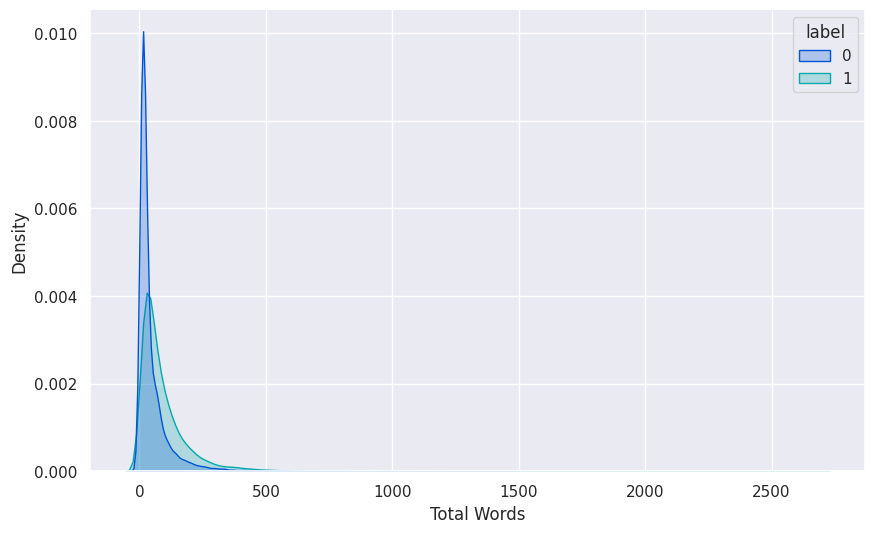

In [16]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

**Kdeplot by Total Chars**

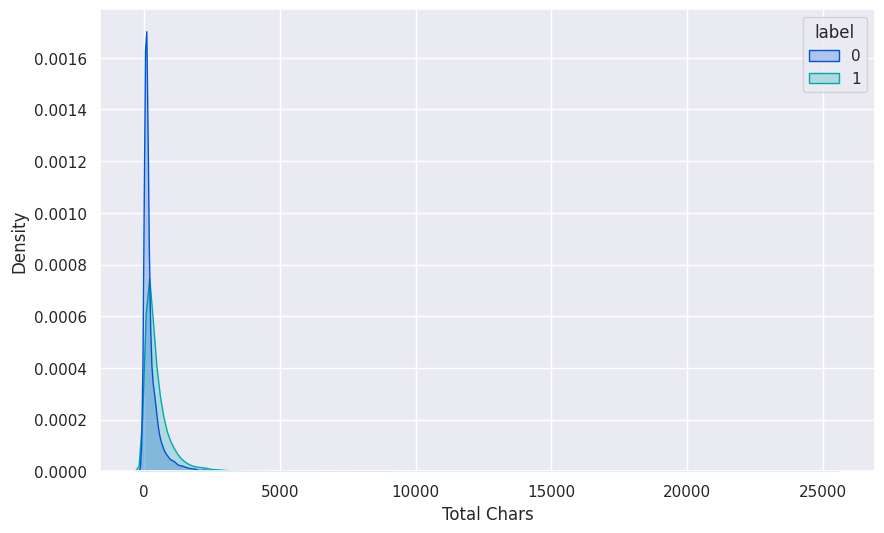

In [17]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

# Preprocessing

To Lowercase

In [18]:
def convert_lowercase(text):
    text = text.lower()
    return text

data['text'] = data['text'].apply(convert_lowercase)

Removing URLs

In [19]:
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['text'] = data['text'].apply(remove_url)

Removing Punctuations

In [20]:
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['text'] = data['text'].apply(remove_punc)

Removing Stopwords

In [24]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

data['text'] = data['text'].apply(remove_stopwords)

Stemming

In [25]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

data['text'] = data['text'].apply(perform_stemming)

New Column: Total words after reformatting

In [28]:
data['Total Words After Transformation'] = data['text'].apply(lambda x: np.log(len(x.split())))
data.head()

,text,label,Total Words,Total Chars,Total Words After Transformation
0,dear american teen question dutch person heard...,0,23,112,3.135494
1,noth look forward lifei dont mani reason keep ...,1,20,98,2.944439
2,music recommend im look expand playlist usual ...,0,64,387,4.110874
3,im done tri feel betterth reason im still aliv...,1,100,493,4.574711
4,worri year old girl subject domest physicalmen...,1,311,1819,5.690359


## Data Visualization

Wordcloud Label=0

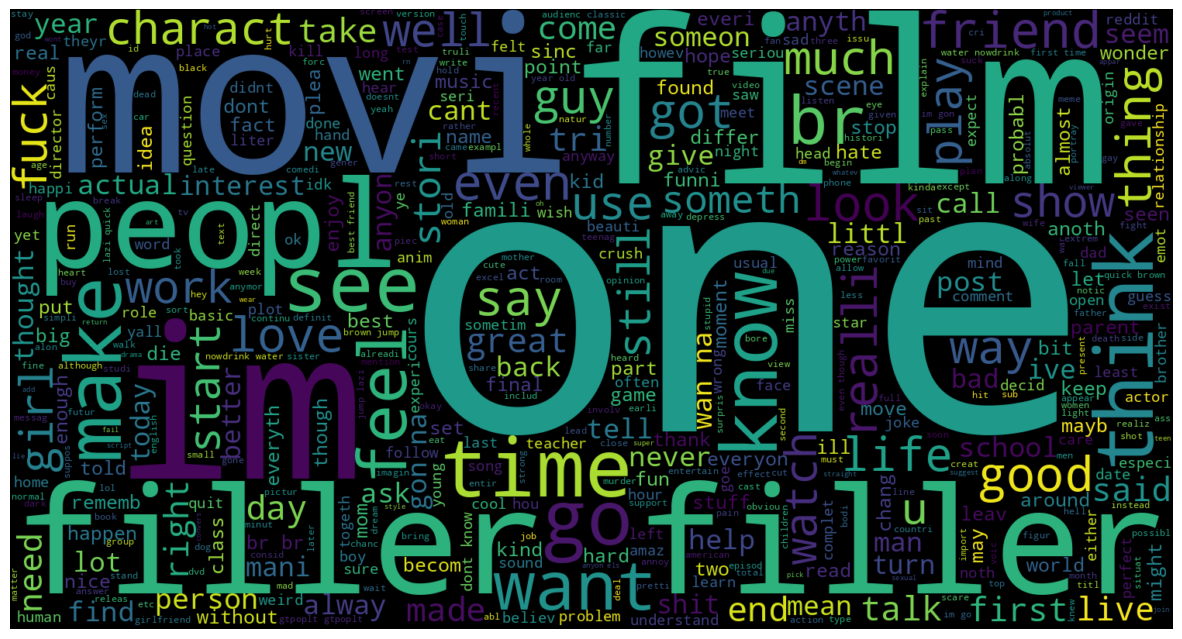

In [29]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Wordcloud Label=1

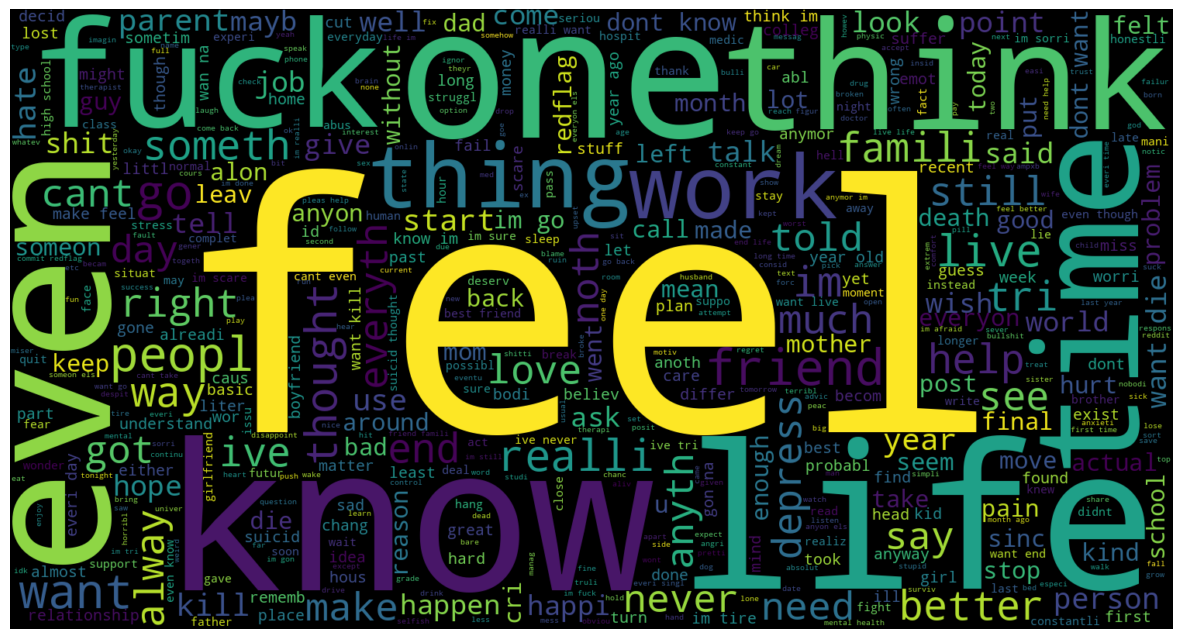

In [30]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Word Frequency Label=0

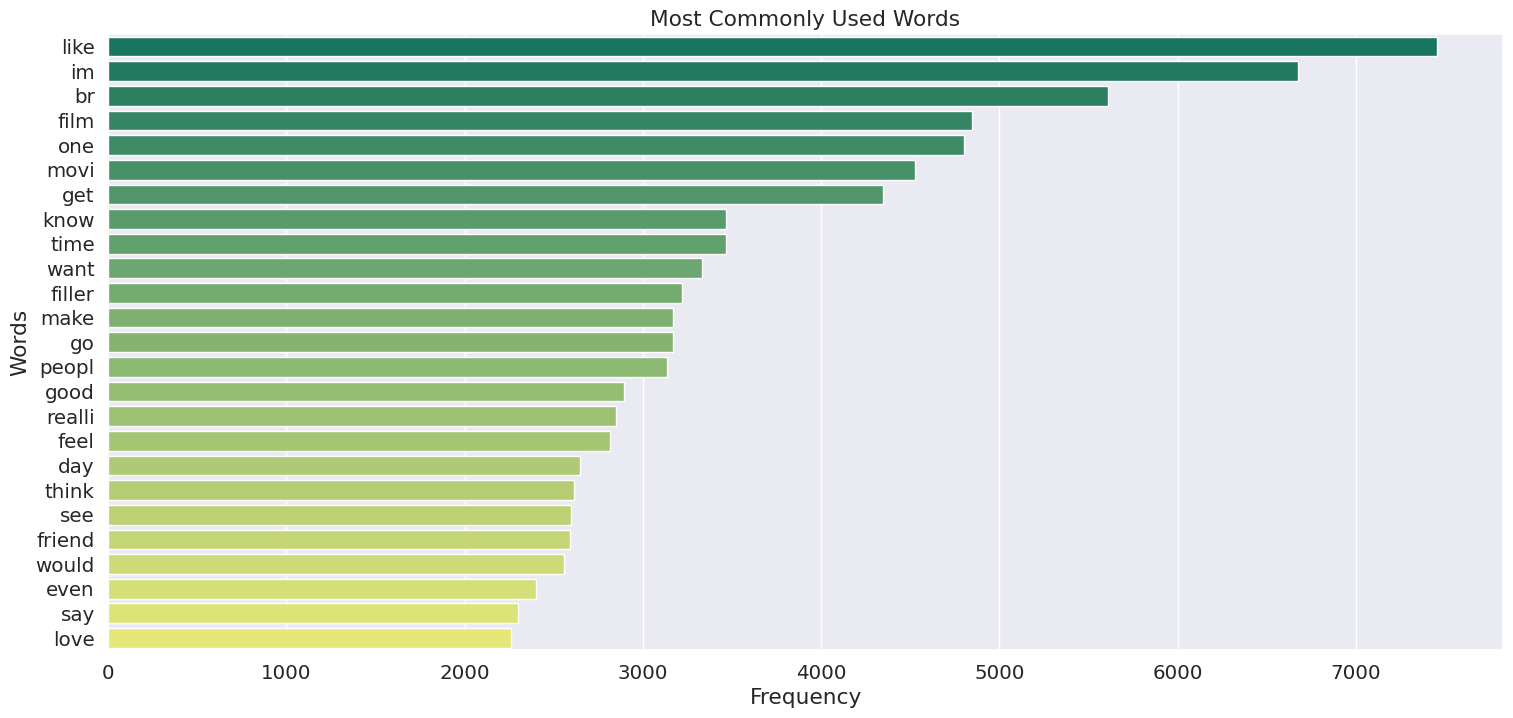

In [43]:
all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

Word Frequency Label=1

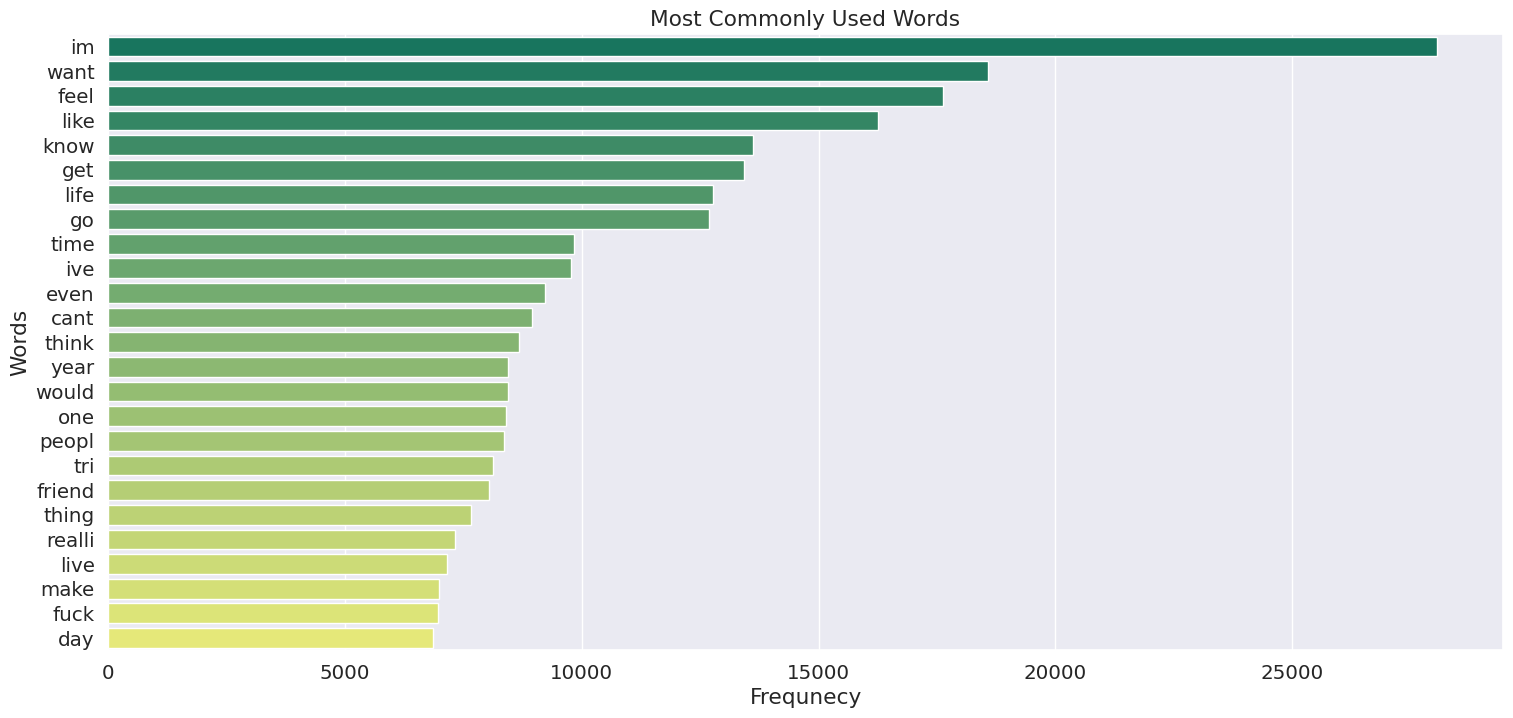

In [32]:
all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

## Training Model

Naive Bayes Algorithm

In [33]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [34]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Accuracy of the model: 0.888
Precision Score of the model: 0.839
Recall Score of the model: 0.957


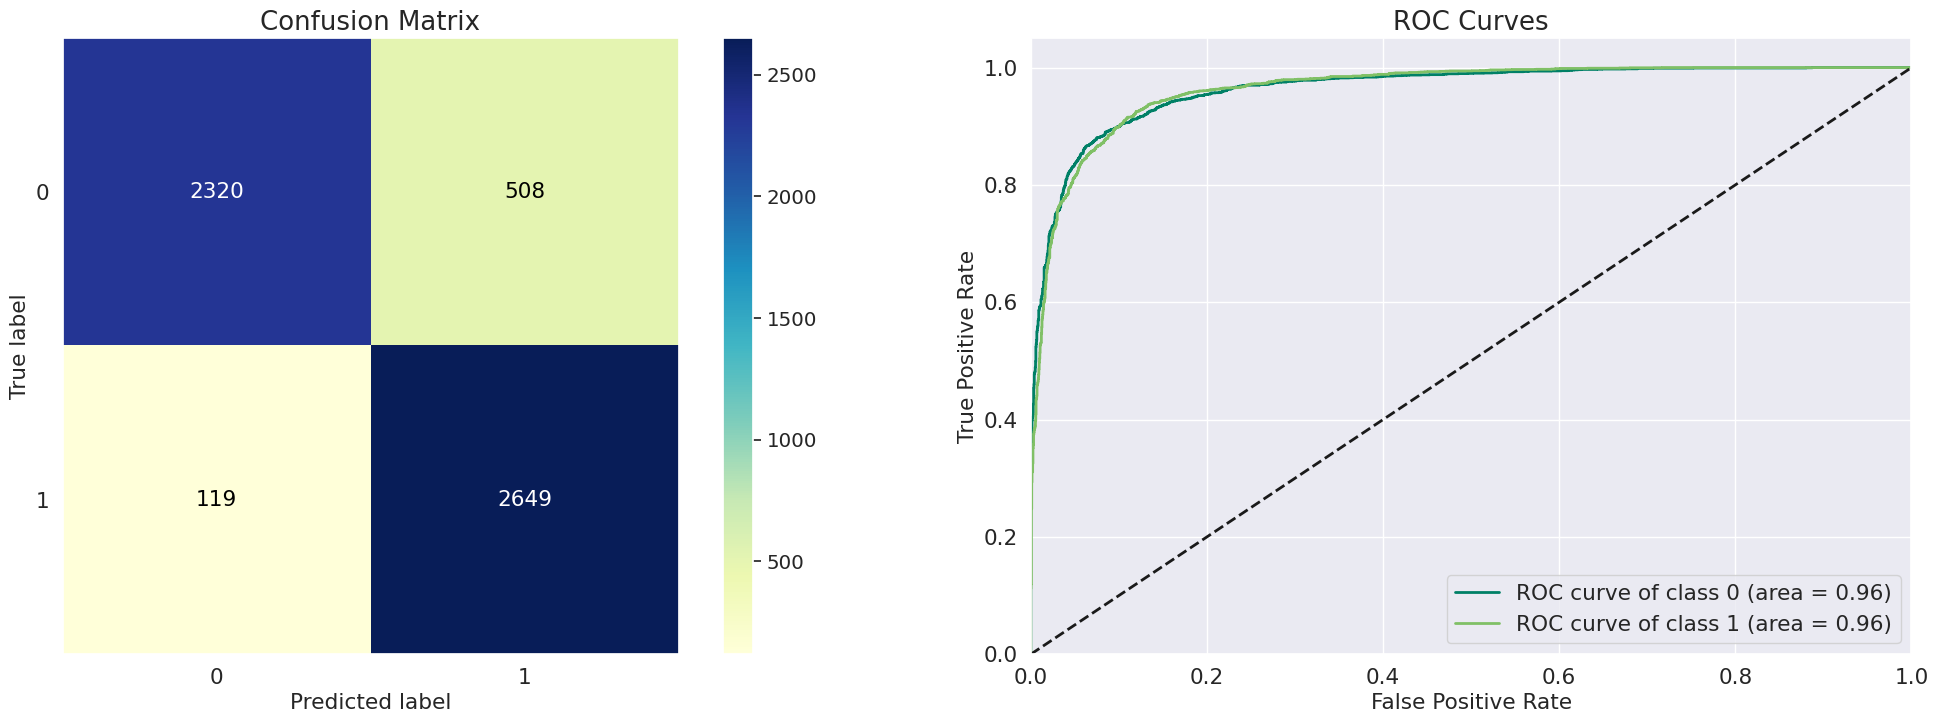

In [35]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

nb = MultinomialNB()
train_model(nb)

Random Forest Classifier

Accuracy of the model: 0.891
Precision Score of the model: 0.881
Recall Score of the model: 0.902


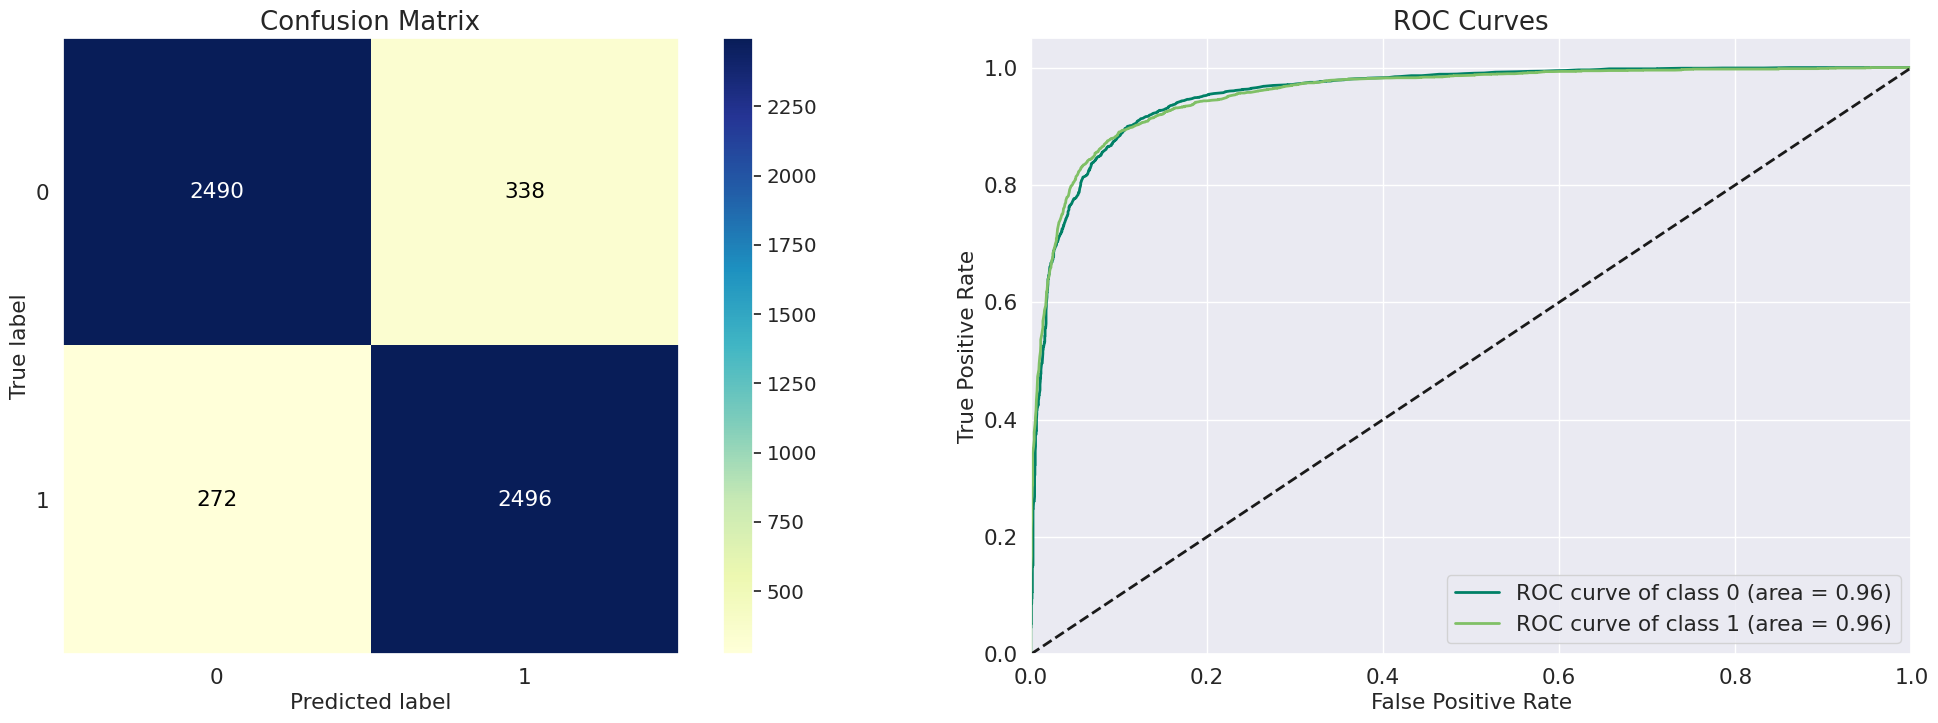

In [36]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

LSTM Model

In [37]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [38]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(data['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 dear american teen question dutch person heard guy get way easier thing learn age us sooooo thth grader like right guy learn math 

After Tokenization & Padding 
 [1890  719  805  288 4306   68  558  108    5   37  771   21  338  344
  158    2   71  108  338 1028    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [39]:
y = data.label
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (15666, 100) (15666,)
Validation Set: (6715, 100) (6715,)
Test Set:       (5596, 100) (5596,)


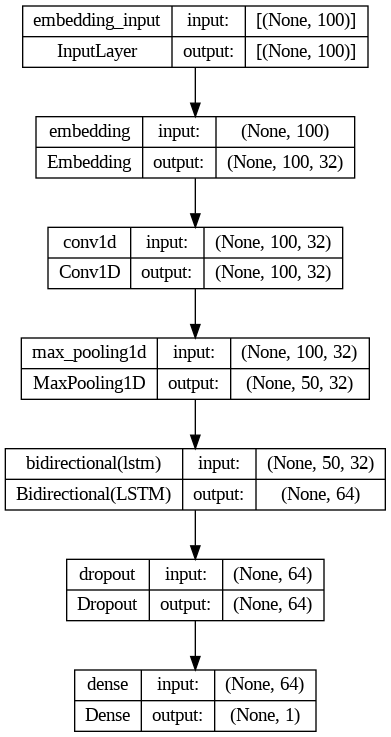

In [40]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

plot_model(model, show_shapes = True)

In [41]:
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=[tf.keras.metrics.Recall(),'accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [42]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
245/245 [==============================] - 33s 90ms/step - loss: 0.6922 - recall: 0.1928 - accuracy: 0.5384 - val_loss: 0.6909 - val_recall: 0.2942 - val_accuracy: 0.5997
Epoch 2/50
245/245 [==============================] - 18s 74ms/step - loss: 0.6901 - recall: 0.2842 - accuracy: 0.5818 - val_loss: 0.6889 - val_recall: 0.3249 - val_accuracy: 0.6101
Epoch 3/50
245/245 [==============================] - 18s 75ms/step - loss: 0.6877 - recall: 0.4519 - accuracy: 0.6089 - val_loss: 0.6859 - val_recall: 0.3135 - val_accuracy: 0.6057
Epoch 4/50
245/245 [==============================] - 17s 70ms/step - loss: 0.6843 - recall: 0.3674 - accuracy: 0.6109 - val_loss: 0.6811 - val_recall: 0.3650 - val_accuracy: 0.6201
Epoch 5/50
245/245 [==============================] - 22s 89ms/step - loss: 0.6776 - recall: 0.4442 - accuracy: 0.6234 - val_loss: 0.6719 - val_recall: 0.4288 - val_accuracy: 0.6387
Epoch 6/50
245/245 [==============================] - 18s 75ms/step - loss: 0.6635 - recal

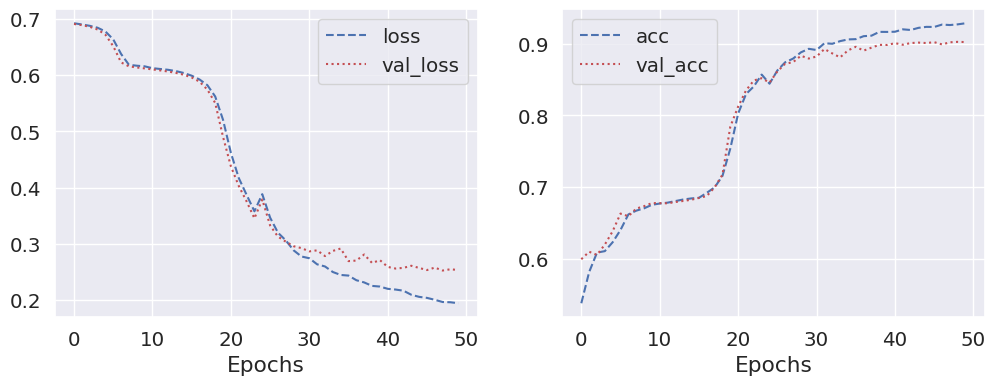

In [44]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [46]:
loss, accuracy,recall= model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Recall  : {:.4f}'.format(recall))

Accuracy  : 0.9021
Recall  : 0.9030
